In [26]:
!pip install arff

  Preparing metadata (setup.py) ... done
  Created wheel for arff: filename=arff-0.9-py3-none-any.whl size=4971 sha256=8830b01ae4245f8a8515abfca4e63760cde1391f716a9af078131092ef5364f0
  Stored in directory: /root/.cache/pip/wheels/fe/81/bd/4ae90e24ba860304e375da219f9205b2586dbee255f3ee70e2
Successfully built arff


In [52]:
import os
import cv2
import time
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import re
import torch
import spacy
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from collections import Counter

from skmultilearn.dataset import load_dataset
from skmultilearn.problem_transform import ClassifierChain, LabelPowerset
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.cluster import NetworkXLabelGraphClusterer
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
from skmultilearn.ensemble import LabelSpacePartitioningClassifier
from sklearn.metrics import roc_auc_score

from sklearn.svm import SVC
import time

In [23]:
train_df = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")
train_df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


**Data cleanining and preprocessing**

In [ ]:
test = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/test.csv")
test_labels = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv")
test_df = pd.merge(test, test_labels, left_on='id', right_on='id', how='left')
drop_idxs = test_df[
    (test_df.toxic == -1) | (test_df.severe_toxic == -1) | (test_df.obscene == -1) | 
    (test_df.threat == -1) | (test_df.insult == -1) | (test_df.identity_hate == -1)
].index
test_df = test_df.drop(drop_idxs, axis="rows")

test_df.head()


In [ ]:
def preprocess_text(text, lower_case=True, clean_text=True):
    
    if lower_case:
        text = text.lower()
    
    # Remove website links
    template = re.compile(r'https?://\S+|www\.\S+') 
    text = template.sub(r'', text)
    
    # Remove HTML tags
    template = re.compile(r'<[^>]*>') 
    text = template.sub(r'', text)
    
    # Remove none ascii characters
    template = re.compile(r'[^\x00-\x7E]+') 
    text = template.sub(r'', text)
    
    # Replace none printable characters
    template = re.compile(r'[\x00-\x0F]+') 
    text = template.sub(r' ', text)
    
    if clean_text:
        # Remove special characters
        text = re.sub("'s", '', text)
        template = re.compile('["#$%&\'()\*\+-/:;<=>@\[\]\\\\^_`{|}~]') 
        text = template.sub(r' ', text)
        # Replace multiple punctuation 
        text = re.sub('[.!?]{2,}', '.', text)
        text = re.sub(',+', ',', text) 
        # Remove numbers
        text = re.sub('\d+', ' ', text) 
        
    # Remove extra spaces
    text = re.sub('\s+', ' ', text)
    
    # Remove spaces at the beginning and at the end of string
    text = text.strip() 

    return text

In [ ]:
train_df["comment_text"] = train_df["comment_text"].map(lambda com : preprocess_text(com))
test_df["comment_text"] = test_df["comment_text"].map(lambda com : preprocess_text(com))

In [ ]:
train_df[['toxic','severe_toxic','obscene', 'threat', 'insult', 'identity_hate']].sum(axis =0 )

In [ ]:
train_df.head()

In [ ]:
test_df[['toxic','severe_toxic','obscene', 'threat', 'insult', 'identity_hate']].sum(axis =0 )

In [ ]:
import gensim.downloader
glove_emb = gensim.downloader.load('glove-wiki-gigaword-100')

In [24]:
weights = glove_emb.get_normed_vectors()
weights.shape

(400000, 100)

In [46]:
def get_dict(df_clean):
    
    reviews = [str(review).split(' ') for review in list(df_clean['comment_text'] )]
    word_freq = Counter([token for review in reviews for token in review]).most_common()

    word_freq = dict(word_freq)
    min_freq = 5
    word_dict = {}


    # sending all the unknowns to 0
    i = 1
    for word in word_freq:
        if word_freq[word] > min_freq:
            word_dict[word] = i
            i += 1
        else:
            word_dict[word] = 0


    max_length = 0
    for idx in tqdm(range(len(df_clean))):
        row = df_clean.iloc[idx]
        length = len(str(row['comment_text']).split(' '))
        if length > max_length:
            max_length = length
            
    return max_length+1, word_dict

max_length, word_dict = get_dict(train_df)

  0%|          | 0/159571 [00:00<?, ?it/s]

In [28]:
X_train, y_train, feature_names, label_names = load_dataset('emotions', 'train')
X_test, y_test, _, _ =load_dataset('emotions', 'test')

emotions:train - does not exists downloading
Downloaded emotions-train
emotions:test - does not exists downloading
Downloaded emotions-test


In [29]:
X_train.shape, y_train.shape

((391, 72), (391, 6))

In [30]:
import warnings
warnings.filterwarnings("ignore")

In [31]:
def custom_tokenizer(tokenizer, df):
    '''
    Input: tokenizer, df
    output: cleaned and tokenized column "cleaned" in df_clean
    '''
    rows = []
    for idx in tqdm(range(len(df))):
        row = df.iloc[idx].copy()

        # first we remove numeric characters and lowercase everything
        cleaned_review = re.sub("[^A-Za-z']+", ' ', row['comment_text'].replace('<br />', ' ')).lower()

        # we let spaCy tokenize and lemmatize the text for us
        tokenized_review = tokenizer(cleaned_review)
        cleaned_tokenized = [token.lemma_ for token in tokenized_review if ((not token.is_stop) or (' ' in token.text))]

        if len(cleaned_tokenized) > 1:
            row['cleaned'] = ' '.join(cleaned_tokenized)
        rows.append(row)
    df_clean = pd.DataFrame(rows)
    return df_clean

In [59]:
train_df_sample = train_df.sample(n=100000, random_state=1)

In [61]:
train_df.shape

(159571, 8)

In [62]:
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])
train_df_sample_clean = custom_tokenizer(nlp, train_df_sample)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [63]:
weights = glove_emb.get_normed_vectors()
unk_emb = weights.mean(axis = 0)
weights_updated = np.concatenate((weights, unk_emb.reshape(1,-1)))
weights_updated.shape

(400001, 100)

In [64]:
def get_cbow_vec(df,weights):
    X = np.zeros((df.shape[0],weights.shape[1]))
    Y = np.zeros((df.shape[0],6))
    for row_idx in range(df.shape[0]):
        row = df.iloc[row_idx]
        comment_text = str(row['cleaned']).split(' ')
        x = torch.zeros((weights.shape[1]))

        # get review as a list of integers
        n = 0
        for idx in range(len(comment_text)):
            x += word_dict.get(comment_text[idx],len(word_dict))
            n+=1
        X[row_idx,:] = x/n
        Y[row_idx] = row[2:8].values
        # embedding likes long tensors
    return X,Y

In [65]:
X_train,Y_train = get_cbow_vec(train_df_sample_clean,weights)

**REFERENCE:http://scikit.ml/modelselection.html**

In [ ]:
import time

start = time.time()

parameters = {
    'classifier': [LabelPowerset(), ClassifierChain()],
    'classifier__classifier': [RandomForestClassifier()],
    'classifier__classifier__n_estimators': [10, 50],
    'clusterer' : [
        NetworkXLabelGraphClusterer(LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False), 'louvain')
    ]
}

clf = GridSearchCV(LabelSpacePartitioningClassifier(), parameters, scoring = 'f1_macro')
clf.fit(X, Y)

print(clf.best_params_, clf.best_score_)
end = time.time()
print(f'{round(end - start)} s')

In [ ]:
import pickle
filename = '../working/gridsearchrf.pkl'

pickle.dump(clf,open(filename, 'wb'))

In [38]:
import pickle
filename = '../input/model/gridsearchrf.pkl'
clf = pickle.load(open(filename,'rb'))

**Training set AUC score**

In [66]:
Y_pred = clf.predict_proba(X_train)
roc_auc_score(Y_train, Y_pred.toarray(), average='micro')

0.5494240720659477

In [39]:
clf.estimator

LabelSpacePartitioningClassifier(require_dense=[True, True])

In [43]:
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])
test_df_sample_clean = custom_tokenizer(nlp, test_df)

  0%|          | 0/63978 [00:00<?, ?it/s]

In [47]:
X_test,Y_test = get_cbow_vec(test_df_sample_clean,weights)

In [49]:
Y_pred = clf.predict_proba(X_test)

**Final AUC score of Random forest based CBOW model on test data**

In [58]:
roc_auc_score(Y_test, Y_pred.toarray(), average='micro')

0.5591345346729509

In [68]:
X = []
for items in train_df['comment_text']:
    X.append(preprocess_text(items))

In [69]:
commonWord = ' '.join(X)

In [70]:
from wordcloud import WordCloud,STOPWORDS
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(commonWord)

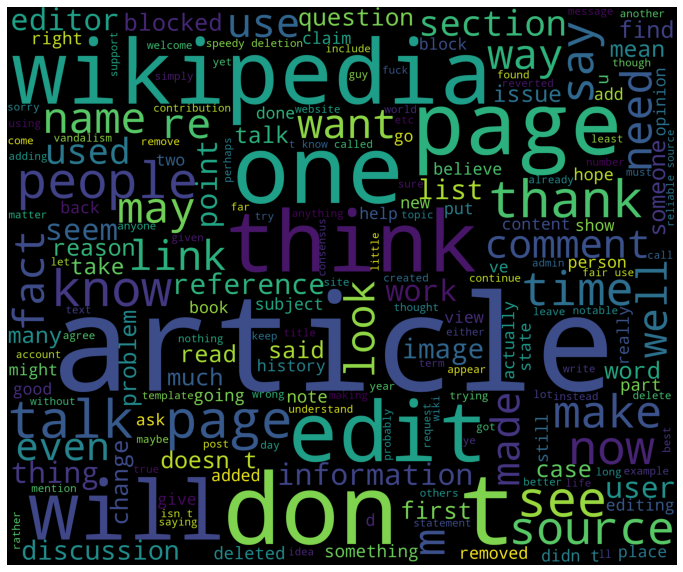

In [71]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()